# Getting Started Code for [F1 Speed Recognition Challenge](https://www.aicrowd.com/challenges/speedrecognition) on AIcrowd

## Steps

1. Use **clustering** to get the type of speedometer.
2. Make the pixels around the speed into white to **localize** the text (which of considered for us)
3. Apply **OCR** to detect the text from the images.
4. Use **Image Regression** to train the model.
5. Use Ensemble the ocr output,Image Regression output.

# Step 1: Download Packages & Data

## Download Necessary Packages 📚

In [1]:
!pip install --upgrade fastai

     |████████████████████████████████| 204kB 3.9MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
!pip install -U aicrowd-cli

     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 174kB 4.9MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 92kB 6.6MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 204kB 36.4MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: click 8.0.0


## Download Data ⏬
The first step is to download out train test data. We will be training a model on the train data and make predictions on test data. We submit our predictions.


In [4]:
API_KEY = '9cce69d6577e95bdcfaf107bb38f8ff2' #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [5]:
!aicrowd dataset download --challenge f1-speed-recognition

sample_submission.csv: 100% 97.8k/97.8k [00:00<00:00, 661kB/s]
test.zip: 100% 96.9M/96.9M [00:03<00:00, 30.1MB/s]
train.csv: 100% 407k/407k [00:00<00:00, 1.33MB/s]
train.zip: 100% 385M/385M [00:11<00:00, 34.5MB/s]
val.csv: 100% 36.7k/36.7k [00:00<00:00, 539kB/s]
val.zip: 100% 37.8M/37.8M [00:17<00:00, 2.16MB/s]


Below, we create a new directory to put our downloaded data! 🏎

We unzip the ZIP files and move the CSVs.

In [6]:
!rm -rf data
!mkdir data

!unzip -q train.zip  -d data/train
!unzip -q val.zip -d data/val
!unzip -q test.zip  -d data/test

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

In [7]:
!rm -rf ./test.zip ./val.zip ./train.zip

# Step2: Perform Clustering to get the labels of two types of speedometers


In [17]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np

In [9]:
!git clone https://github.com/zegami/image-similarity-clustering.git

Cloning into 'image-similarity-clustering'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 154 (delta 76), reused 79 (delta 34), pack-reused 20
Receiving objects: 100% (154/154), 42.29 KiB | 3.84 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [10]:
%cd ./image-similarity-clustering

/content/image-similarity-clustering


In [12]:
from features import extract_features
from tsne_reducer import tsne
from parse_data import parse_data
from umap_reducer import umap
from sklearn.cluster import KMeans

In [13]:
def get_labels(directory):
    features = extract_features(directory)
    features.to_csv("features.csv",index=False)

    data = parse_data('features.csv', feature_cols='all', unique_col='A')
    reduced_2 = umap(data, write_to='umap_features.csv')

    model = KMeans(n_clusters=2, n_jobs=-1, random_state=728)
    model.fit(reduced_2[[0,1]])
    predictions = model.predict(reduced_2[[0,1]])
    
    image_cluster = pd.DataFrame()
    image_cluster['ImageID'] = reduced_2['ID']
    image_cluster['label'] = pd.DataFrame(predictions)[0]
    image_cluster['ImageID'] = image_cluster['ImageID'].apply(lambda x: int(x.split(".")[0]))
    image_cluster = image_cluster.sort_values(['ImageID']).reset_index(drop=True)
    return image_cluster

In [ ]:
#Cluster Test Data
image_cluster = get_labels('../data/test')
image_cluster.to_csv('../test_label.csv',index=False)

#Cluster Validation Data
image_cluster = get_labels('../data/val')
image_cluster.to_csv('../val_label.csv',index=False)

#Cluster Train Data
image_cluster = get_labels('../data/train')
image_cluster.to_csv('../train_label.csv',index=False)

# Step 3: Localize the text by convert surrounding pixels into white

In [15]:
%cd /content

/content


In [ ]:
test_1 = pd.read_csv("./test_label.csv")
val_1 = pd.read_csv("./val_label.csv")
train_1 = pd.read_csv("./train_label.csv")

In [ ]:
!mkdir dataset
!mkdir dataset/train
!mkdir dataset/test
!mkdir dataset/val


def crop_images(data_dir,target_dir,label_file_dir):
    
    label_df =  pd.read_csv(label_file_dir)
    
    for image in tqdm(os.listdir(data_dir)): #os.listdir(data_dir)

        img = Image.open(os.path.join(data_dir,image)).convert('RGB')
  
        # Extracting the image data &
        # creating an numpy array out of it
        img_arr = np.array(img)
         
        label = label_df[label_df['ImageID']==int(image.split(".")[0])]['label'].values[0]
        #print(label)
        if label==0:
            # Turning the pixel values of the 400x400 pixels to white 
            img_arr[0 : 256, 0 : 100] = (255, 255, 255)
            img_arr[0 : 256, 160 : 256] = (255, 255, 255)
            img_arr[0 : 130, 80 : 180] = (255, 255, 255)
            img_arr[170 : 256, 80 : 180] = (255, 255, 255)
        else:
            # Turning the pixel values of the 400x400 pixels to white 
            img_arr[0 : 256, 0 : 80] = (255, 255, 255)
            img_arr[0 : 256, 180 : 256] = (255, 255, 255)
            img_arr[0 : 100, 80 : 180] = (255, 255, 255)
            img_arr[155 : 256, 80 : 180] = (255, 255, 255)

        img = Image.fromarray(img_arr)
      
        #return img
        img.save(os.path.join(target_dir,image))
        
        
    
data_dir = "./data/train"
target_dir = "./dataset/train"
label_file_dir = "./train_label.csv"
crop_images(data_dir,target_dir,label_file_dir)

data_dir = "./data/test"
target_dir = "./dataset/test"
label_file_dir = "./test_label.csv"
crop_images(data_dir,target_dir,label_file_dir)


data_dir = "./data/val"
target_dir = "./dataset/val"
label_file_dir = "./val_label.csv"
crop_images(data_dir,target_dir,label_file_dir)

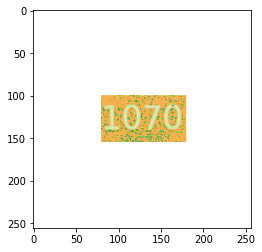

In [24]:
plt.imshow(cv2.imread("./dataset/test/0.jpg"))

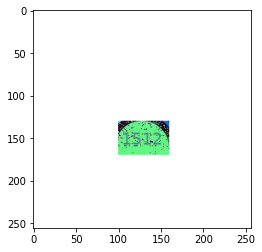

In [22]:
plt.imshow(cv2.imread("./dataset/test/1.jpg"))


## Import packages

In [ ]:
import pandas as pd
from fastai.vision.all import *
from fastai.data.core import *
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

seed_value =2021
use_cuda = True

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
random_seed(seed_value, use_cuda)


## Load Data
- We use pandas 🐼 library to load our data.   
- Pandas loads the data into dataframes and facilitates us to analyse the data.   
- Learn more about it [here](https://www.tutorialspoint.com/python_data_science/python_pandas.htm) 🤓

In [25]:
data_folder = "data"

In [26]:
train_df = pd.read_csv(os.path.join(data_folder, "train.csv"))
val_df = pd.read_csv(os.path.join(data_folder, "val.csv"))

## Visualize the data 👀

Using Pandas and the Matplot Library in Python, we will be viewing the images in our datasets.

In [27]:
train_df.head()

ImageID  label
0        0   1528
1        1    929
2        2   1504
3        3    938
4        4   1736

Adding .jpg to all the ImageIDs in "ImageID" column. This will help us with adding the path behind the names of these images.

In [ ]:
train_df['ImageID'] = train_df['ImageID'].astype(str)+".jpg"
val_df['ImageID'] = val_df['ImageID']+40000
val_df['ImageID'] = val_df['ImageID'].astype(str)+".jpg"


dir_ = "./dataset/val"
for i in tqdm(os.listdir(dir_)):
    os.rename(os.path.join(dir_,i),os.path.join(dir_,str(int(i.split(".")[0])+40000))+".jpg")
    
val_df['is_valid'] = True
train_df['is_valid'] = False
df = pd.concat([train_df,val_df])

!cp -r ./dataset/val/. ./dataset/train/.

len(os.listdir("./dataset/train")) #44000

# Step 4: TRAINING PHASE [ Image Regression]
Now that we have the dataset is ready, it's time to create a model that we will train on our data!

In [ ]:
data_folder = "./dataset"
dls = ImageDataLoaders.from_df(df, path=os.path.join(data_folder, "train"), bs=16, y_block=RegressionBlock,valid_col='is_valid')
dls.show_batch()

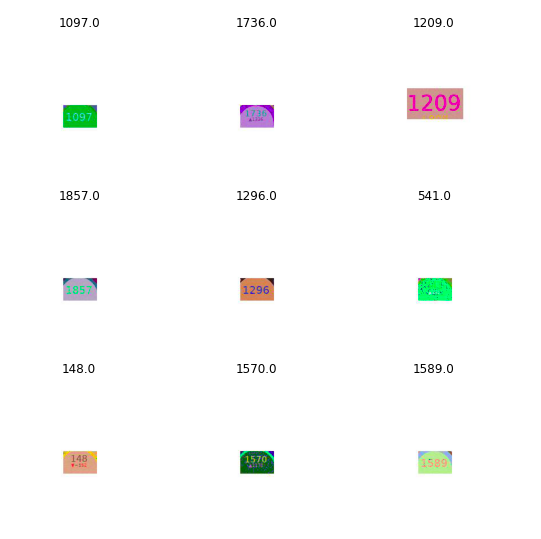

### Models Used for ensemble
1. resnet18
2. vgg19
3. resnet50 

In [ ]:
learn = cnn_learner(dls, models.resnet18, metrics=mse)

In [ ]:
learn.fine_tune(20)

In [ ]:
learn.fine_tune(3,base_lr=0.05)

In [ ]:
learn.fine_tune(4,base_lr=0.001)

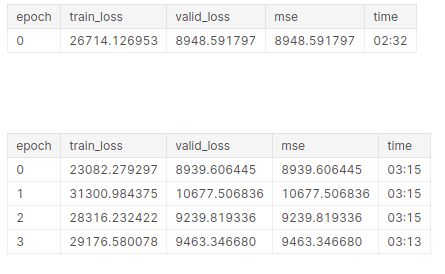

## Testing Phase 😅
We are almost done. We trained and validated on the training data. Now its the time to predict on test set and make a submission.

## Load Test Set
Load the test data on which final submission is to be made.

In [ ]:
test_imgs_name = get_image_files(os.path.join(data_folder, "test"))
test_dls = dls.test_dl(test_imgs_name)

test_img_ids = [re.sub(r"\D", "", str(img_name)) for img_name in test_imgs_name]

In [ ]:
test_dls.show_batch()

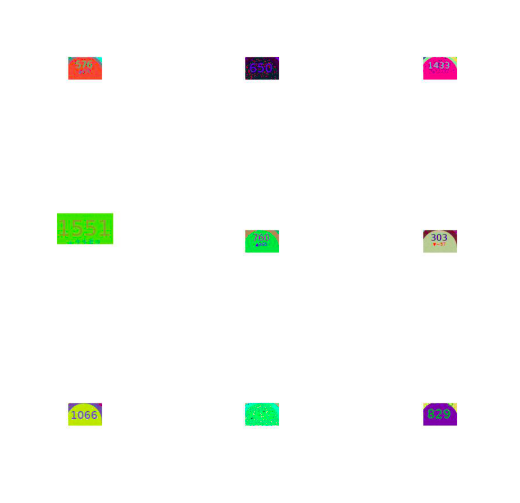

## Predict Test Set
Predict on the test set and you are all set to make the submission!



In [ ]:
_,_,results = learn.get_preds(dl = test_dls, with_decoded = True)

results = [i[0] for i in results.numpy()]

## Save the prediction to csv

In [ ]:
submission = pd.DataFrame({"ImageID":test_img_ids, "label":results})
submission

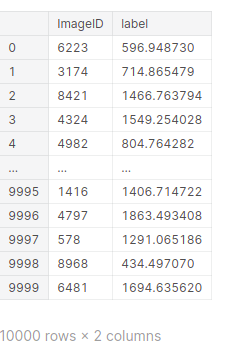

In [ ]:
submission.to_csv("submission_regression.csv", index=False)

# Step 5: Apply OCR on Test Set

In [ ]:
!pip install easyocr

In [ ]:
import easyocr
reader = easyocr.Reader(['en'],gpu = True) # need to run only once to load model into memory

In [ ]:
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[2],reverse=True)
    return sub_li

def get_predictions(img_path):
    
    img = cv2.imread(img_path)
    median_blur= cv2.medianBlur(img, 3)

    kernel = np.array([[-1,-1,-1], 
                           [-1, 9,-1],
                           [-1,-1,-1]])

    sharpened = cv2.filter2D(median_blur, -1, kernel) 

    result = reader.readtext(sharpened)
    result = Sort(result)
    
    count =0
    for i in result:
        if i[1].replace(',','').isdigit():
          return i[1].replace(',',''),i[2]


def ocr_predictions_images(data_dir):
    
    predictions =  {}
    for image in tqdm(os.listdir(data_dir)):
        
        img_path = os.path.join(data_dir,image)
        predictions[int(image.split(".")[0])] = get_predictions(img_path)

    return predictions

data_dir = "./dataset/test"
predictions = ocr_predictions_images(data_dir)

In [ ]:
data = pd.DataFrame.from_dict(predictions, orient="index",columns=['label']).reset_index()
data = data.rename(columns={"index":"ImageID"})

data['label'] = data['label'].fillna(np.nan)

In [ ]:
data.to_csv("ocr_result.csv",index=False)

# Step 6: Ensemble

Note: **Most of the predictions difference (between regression & ocr) were in between 0 to 158**, so if the difference was less than 158, then the regression result was replaced with ocr.

In [ ]:
def process(x):
    global c
    if np.isnan(x[1]):
        return x[2]
    elif (x[1]>=0)and(x[3]<158): #120
        return x[0]
    else:
        return x[2]

In [ ]:
df = pd.read_csv("submission_regression_ensemble.csv").sort_values('ImageID').reset_index(drop=True)
data = pd.read_csv("ocr_result.csv").sort_values('ImageID').reset_index(drop=True)

data['label1'] = data['label'].apply(lambda x: x if x is np.nan else float(x.split(",")[0].split('(')[-1] ))
data['acc'] = data['label'].apply(lambda x: x if x is np.nan else float(x.split(",")[1].split(')')[0]) )

data['label_df'] = df['label']
data['diff'] = abs(data['label_df'] - data['label1'])

In [ ]:
df['label'] = data[['label1','acc','label_df','diff']].apply(lambda x: process(x),axis=1)

In [ ]:
df.to_csv("submisson.csv",index=False)

In [ ]:
!aicrowd submission create -c f1-speed-recognition -f submission.csv

## Observations
1. Ensemble of Multiple Models used for Image regression
2. OCR for accurate predictions 
3. Ensemble of both these approaches provided the best result.